In [1]:
# Load the Excel file
file_path = "All Data.xlsx"

=== Storm Damage Forecast Program ===

Available ISO codes (Countries):
- USA
- JAM
- JPN
- TUR
- IND
- CPV
- UGA
- GTM
- MMR
- MTQ
- VCT
- SUN
- CHN
- CAN
- COM
- ISR
- IRN
- NER
- BGD
- TWN
- GRC
- ITA
- PHL
- ALB
- COL
- CHL
- HKG
- ROU
- IDN
- FRA
- HTI
- MAR
- PRT
- PAK
- CRI
- DZA
- BFA
- GMB
- GNB
- MLI
- MRT
- SEN
- TCD
- KAZ
- MEX
- PER
- TKL
- PRI
- NZL
- AIA
- DFR
- ARG
- ECU
- BHS
- CUB
- EGY
- JOR
- BGR
- POL
- GLP
- MSR
- KNA
- BEL
- DOM
- NIC
- FJI
- BLZ
- HND
- SLB
- ARM
- TTO
- SLV
- NOR
- KOR
- PNG
- NCL
- GHA
- AUS
- VUT
- SDN
- ESP
- YMN
- COK
- YUG
- LBY
- TON
- AZO
- BMU
- REU
- BRA
- ATG
- VEN
- CHE
- GBR
- ZAF
- AUT
- NLD
- VNM
- CYP
- IRQ
- AFG
- ANT
- NPL
- BRB
- LBN
- MOZ
- MNG
- LKA
- TUN
- SPI
- PYF
- NIU
- LCA
- MUS
- ETH
- SOM
- THA
- GUM
- DMA
- GRD
- PRY
- SAU
- KEN
- TZA
- PAN
- WSM
- WLF
- MYS
- BOL
- BWA
- TGO
- COD
- LAO
- ASM
- URY
- MWI
- SYR
- COG
- MDG
- LSO
- SUR
- NGA
- BEN
- HUN
- CIV
- GUY
- CMR
- KIR
- TUV
- YMD
- ISL
- CAF
- CSK
- RWA
- SL

C:\Users\milan\AppData\Local\Temp\ipykernel_10776\2359031656.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)
C:\Users\milan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\milan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No

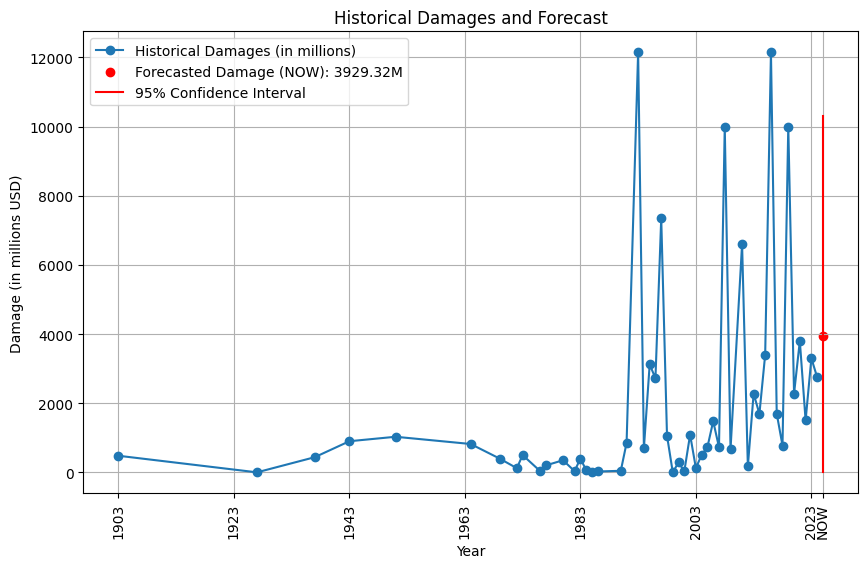

In [2]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import acf

def load_data(file_path):
    try:
        return pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

def cap_outliers(series, threshold=3):
    mean = series.mean()
    std = series.std()
    return series.clip(lower=mean - threshold * std, upper=mean + threshold * std)

def test_seasonality(series, threshold=0.3, seasonal_lag=12):
    """Test for seasonality using autocorrelation at seasonal lag."""
    autocorr = acf(series.dropna(), nlags=seasonal_lag)
    return abs(autocorr[seasonal_lag]) > threshold

def test_trend(series, threshold=0.05):
    """Test for trend using simple linear regression slope significance."""
    x = np.arange(len(series))
    y = series.values
    slope, intercept = np.polyfit(x, y, 1)
    return abs(slope) > threshold

def tune_model(data):
    seasonal = test_seasonality(data)
    trend = test_trend(data)

    if seasonal:
        print("\nSeasonality detected: Using seasonal ETS model.")
    else:
        print("\nNo seasonality detected: Using non-seasonal model.")

    if trend:
        print("Trend detected: Including trend component in model.")
    else:
        print("No significant trend detected: No trend component used.")

    try:
        if seasonal:
            model = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=12, damped_trend=False)
        elif trend:
            model = Holt(data, damped_trend=False)
        else:
            model = ExponentialSmoothing(data, trend=None, seasonal=None)
        fitted_model = model.fit()
        return fitted_model
    except Exception as e:
        print(f"Model fitting failed: {e}")
        return None

def forecast_damage(data, country, disaster_type):
    filtered_data = data[(data['ISO'] == country.upper()) & 
                         (data['Disaster Type'] == disaster_type)]

    if filtered_data.empty:
        return f"No historical data available for {disaster_type} in {country}.", None

    filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)
    
    # Aggregate damage by year
    historical_data = filtered_data[['Year', 'Total Damage (\'000 US$)']].dropna()
    historical_data['Total Damage (Millions)'] = historical_data['Total Damage (\'000 US$)'] / 1_000
    
    # Group by year and sum damages
    historical_data = historical_data.groupby('Year')['Total Damage (Millions)'].sum().reset_index()
    
    historical_data['Total Damage (Millions)'] = cap_outliers(historical_data['Total Damage (Millions)'])
    historical_data.set_index('Year', inplace=True)

    try:
        fitted_model = tune_model(historical_data['Total Damage (Millions)'])
    except Exception as e:
        return f"Model tuning failed: {str(e)}", None

    print("\nModel Parameters:")
    try:
        params = fitted_model.model.params
        print(params)
    except AttributeError:
        print("No detailed parameters available for this model.")

    forecasted_value = fitted_model.forecast(steps=1).iloc[0]
    stderr = np.std(fitted_model.resid)
    ci_upper = forecasted_value + 1.96 * stderr
    ci_lower = max(0, forecasted_value - 1.96 * stderr)

    return round(forecasted_value, 2), round(ci_lower, 2), round(ci_upper, 2), historical_data

def plot_forecast(historical_data, forecasted_value, ci_lower, ci_upper):
    next_year = historical_data.index[-1] + 1
    plt.figure(figsize=(10, 6))
    
    plt.plot(historical_data.index, historical_data['Total Damage (Millions)'],
             label="Historical Damages (in millions)", marker='o')
    
    plt.scatter(next_year, forecasted_value, color='red', label=f"Forecasted Damage (NOW): {forecasted_value}M")
    plt.plot([next_year, next_year], [ci_lower, ci_upper], color='red', linestyle='-', label="95% Confidence Interval")
    
    plt.title("Historical Damages and Forecast")
    plt.xlabel("Year")
    plt.ylabel("Damage (in millions USD)")
    plt.legend()
    plt.grid()

    year_ticks = list(range(historical_data.index.min(), historical_data.index.max() + 1, 20)) + [next_year]
    year_labels = [str(year) for year in year_ticks[:-1]] + ['NOW']
    plt.xticks(year_ticks, labels=year_labels, rotation=90)

    plt.show()

if __name__ == "__main__":
    print("=== Storm Damage Forecast Program ===")

    file_path = "All Data.xlsx"
    data = load_data(file_path)

    if data is not None:
        unique_iso_codes = data['ISO'].dropna().unique()
        print("\nAvailable ISO codes (Countries):")
        for iso_code in unique_iso_codes:
            print(f"- {iso_code}")

        user_country = input("\nEnter the country (ISO code, e.g., 'USA' for United States): ").strip().upper()
        available_disasters_for_country = data[data['ISO'] == user_country]['Disaster Type'].dropna().unique()

        if not available_disasters_for_country.size:
            print(f"No disaster data available for country {user_country}.")
        else:
            print(f"\nAvailable disaster types for {user_country}:")
            for disaster_type in available_disasters_for_country:
                print(f"- {disaster_type}")

            user_disaster_type = input("\nEnter the disaster type (e.g., 'Storm'): ").strip()

            result, ci_lower, ci_upper, historical_data = forecast_damage(data, user_country, user_disaster_type)
            if isinstance(result, float):
                print(f"\nHistorical Damages (in millions):")
                print(historical_data[['Total Damage (Millions)']])
                print(f"\nForecasted damages for {historical_data.index[-1] + 1}: {result} million US dollars")
                print(f"95% Confidence Interval: [{ci_lower}, {ci_upper}] million USD")
                plot_forecast(historical_data, result, ci_lower, ci_upper)
            else:
                print(result)
    else:
        print("Failed to load disaster data.")